<a href="https://colab.research.google.com/github/marques-viniciusc/analise-da-logistica-loggi/blob/main/Projeto_de_estudo_An%C3%A1lise_da_log%C3%ADstica_da_empresa_Loggi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

O projeto a seguir trata de um projeto de estudo, simulando um problema real da empresa de logística Loggi. No projeto sugerido, a empresa necessita otimizar suas entregas no Distrito Fedral.
Para entender o problema, precisamos fazer um levantamento de dados baseados nos hubs de distribuição e nos endereços de entrega da empresa, assim, poderemos entender alguns fenômenos como:


*   Quais regiões em que estão concentradas as entregas?
*   Qual a localização dos hubs de entrega?
*   Há hubs que estão saturados?
*   Há hubs em que há espaço para crescimento?

Para fazer este levantamento vamos usar usar a linguagem Python e principalmente os pacotes Pandas, Matplotlib e Geopy.

Fazendo essa análise inicial poderemos compreender melhor se há como otimizar o processo de entregas bem como a distribuição delas pelos diferentes hubs.

Ao final do projeto, a intenção é poder visualizar estes dados, tanto na forma de tabela, como em gráfico e mapa também, assim, será possível sugerir alterações para otimização no atual formato de entregas utilizado pela empresa.




## 2\. Pacotes e bibliotecas

In [1]:
!pip3 install geopandas;

In [2]:
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopy
import geopandas
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

## 3\. Exploração de dados

Nesta etapa, a intenção é fazer um levantamento dos dados mais relevantes para nosso projeto.

A ideia é conseguir fazer uma limpeza dos dados, descartando dados brutos e que não são necessários (pelo menos à priori) e focando na localização dos hubs e das entregas, tanto dos pontos em si, quanto das regiões. Desta maneira, é possível ter uma visão melhor de qual região abarca qual hub e entrega.

## Coleta e leitura de dados


In [3]:
# coleta e leitura de dados

!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

with open('deliveries.json', mode='r', encoding='utf8') as file:
    data = json.load(file)

## Wrangling dos dados

In [4]:
deliveries_df = pd.DataFrame(data)

hub_df = pd.json_normalize(deliveries_df['origin']) # criação de um df que divida latitude e longitude dos hubs de entrega

deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop(columns='origin')
deliveries_df.rename(columns={'lat': 'hub_lat', 'lng': 'hub_lng'}, inplace=True)
deliveries_df = deliveries_df[['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity', 'deliveries']]

exploded_deliveries_df = deliveries_df[['deliveries']].explode('deliveries')

deliveries_normalized_df = pd.concat([
  pd.DataFrame(exploded_deliveries_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(exploded_deliveries_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(exploded_deliveries_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True) # junção dos dataframes
deliveries_df.drop(columns='deliveries', inplace=True)
deliveries_df.reset_index(drop=True, inplace=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


## 4\. Manipulação

Na etapa da manipulação os dados obtidos acima serão utilizados para encontrar a cidade, região ou subúrbio de entrega.
A principal metodologia para fazer isso foi o uso da geolocalização reversa, que busca os pontos de latitude e longitude e "traduz" para a localização dentro da cidade.
Também foi feita uma checagem de dados para encontrar os dados faltantes (ou nulos) e apurar a qualidade dos dados obtidos.

## Ferramenta para geolocalização reversa dos hubs

In [5]:
geolocator = Nominatim(user_agent="deliveries")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1) # aplicação da geolocalização reversa do Nominatim

## Manipulação de dados para achar os hubs e criar um dataframe com hubs, entregas e coordenadas de ambos

In [6]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]] # criação de um df apenas com as informações dos hubs
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)

hub_df['coordinates'] = hub_df['hub_lat'].astype(str) + ', ' + hub_df['hub_lng'].astype(str)
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)
hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))

## Agregação dos dados de localização, com hierarquia utilizada cidade > município > subúrbio


In [7]:
hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']] # seleção das colunas de interesse do hub
hub_geodata_df = hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'})
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town']) # se não houver cidade, inserir town
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city']) # se não houver subúrbio, inserir cidade
hub_geodata_df = hub_geodata_df.drop(columns=['hub_town'], axis=1) # remoção da coluna town porque não é mais necessária (está dentro das outras duas acima)
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]

## Merge dos dataframes de hubs e deliveries

In [8]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how='inner', on='region')
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


## Geolocalização reversa das entregas

In [9]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv # download do arquivo pronto porque demoraria dias para fazer a busca de cada endereço

In [10]:
deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
deliveries_geodata_df = deliveries_geodata_df[['delivery_city', 'delivery_suburb']]
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df, how='inner', left_index=True, right_index=True, suffixes=('_left', '_right'))

deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


# 5 Visualização dos dados

Por fim, usamos todos os dados acima tratados para visualizar o resultado do trabalho:



*   A visualização do **mapa** nos permite ter uma visão espacial do caso, podendo analisar melhor a distribuição geográfica dos hubs e entregas, permitindo conclusões mais elaboradas e sugestões mais adequadas.
*   A visualização na forma de **gráfico de colunas** nos permite ter uma ideia quantitativa do caso, de forma a complementar os dados espaciais obtidos através do mapa.



In [11]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip # download do dado cru
!unzip -o -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp # seleção do shape e do shx, que é complementar
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [12]:
mapa = geopandas.read_file("distrito-federal.shp") # usando o geopandas para ler o arquivo baixado acima
mapa = mapa.loc[[0]] # lendo apenas a primeira linha pq o arquivo contém DF e GO, queremos só DF

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))

## Plotagem do mapa

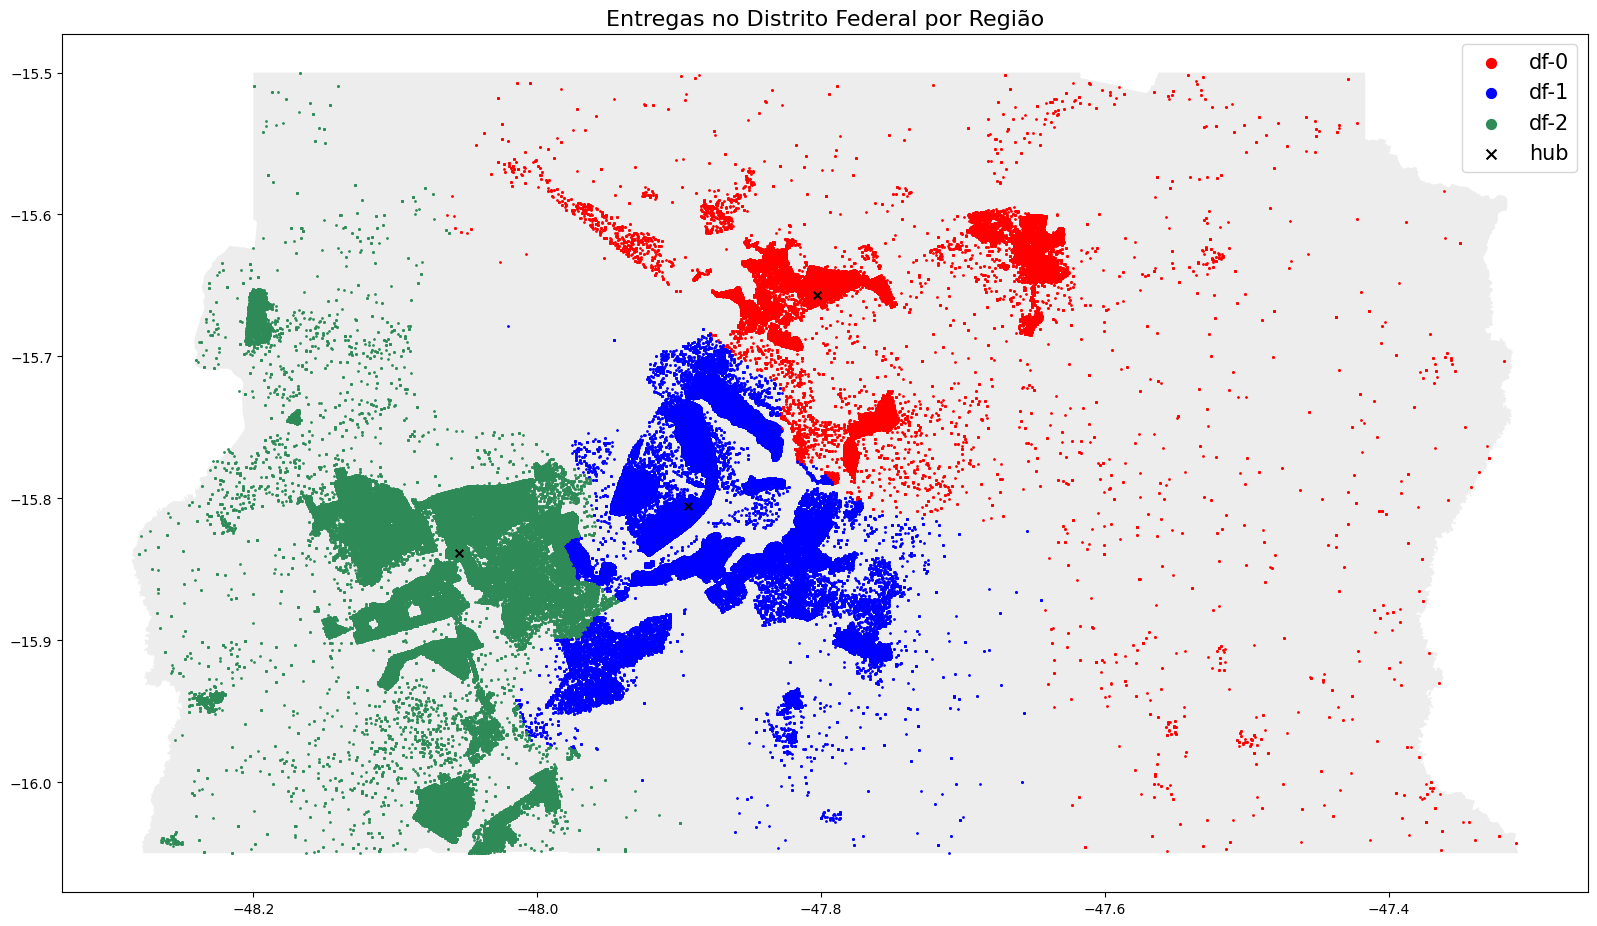

In [13]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54)) # conversão cm para polegadas

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

## Visualização em gráfico de barras

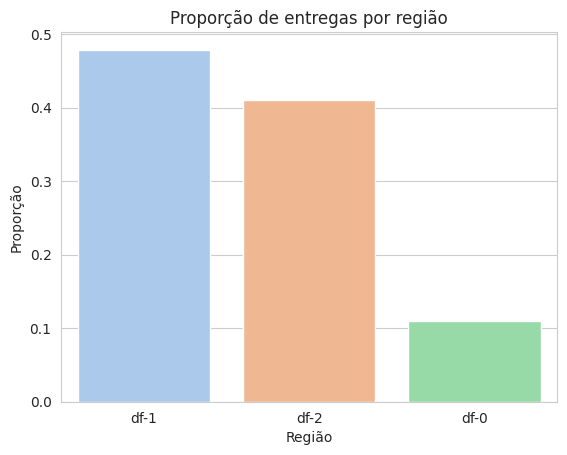

In [14]:
data = deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True).reset_index(name='region_percent') # criação de um df a partir da contagem de quantas vezes uma região aparece em porcentagem (normalize = proporção) e renomeando a coluna que vai surgir com nome de 0 para region_percent

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", errorbar=None, palette="pastel", hue='region')
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção')

## 6. Insights

## Quanto à distribuição geográfica

Através dos dados obtidos e da visualização em mapa, podemos observar uma distribuição pouco uniforme das entregas. A maior parte dos destinos se encontra na região metropolitana de
Brasília, com algumas outras entregas nas cidades-satélites em seu entorno.
Dessa forma, podemos afirmar que faz mais sentido haver maior capacidade de veículos, bem como mais hubs de distribuição em áreas próximas ao centro de Brasília, assim, haverá maior
aproveitamento da capacidade de entrega e de transporte de mercadorias.

## Quanto à capacidade veicular

A capacidade de veículos parece mal aproveitada, uma vez que há a mesma capacidade (180) em todos os hubs de distribuição. Uma vez que há maior concetração de entregas nos hubs df-1
e df-2, a quantidade de veículos provavelmente deveria ser maior. No entanto, pode haver uma possível explicação para este dado, uma vez que o hun df-0 possui uma área de cobertura
maior e atende regiões mais afastadas, podendo fazer com que os veículos passem mais tempo em deslocamento.
